In [42]:
from pyramid.arima import auto_arima
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

import util
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import warnings
import itertools
import pyramid
import datetime as dt

%matplotlib inline


print('numpy version: %r' % np.__version__)
print('pyramid version: %r' % pyramid.__version__)

numpy version: '1.14.0'
pyramid version: '0.6.5'


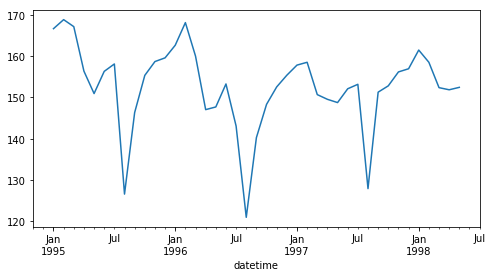

In [137]:
data, meta = util.read_arf('powersupply.arff');

data = list(map(lambda x: (x[0], x[1], int(x[2])), data))

x = list(filter(lambda x: int(x[2]) == 0, data))

dates = pd.date_range('1995-01-01', periods=len(x), freq='D')

x = pd.DataFrame(x)
x.rename(columns={0: 'main_grid',1: 'other_grid', 2: 'hour'}, inplace=True)

# extract only 0 hour
lst = list(filter(lambda x: x.hour == 0,dates))

lst = lst[:len(lst)-((len(lst) - len(x)))]

x['datetime'] = lst
x.set_index('datetime', inplace = True)

x = x.resample('MS').mean();

x = x['main_grid']

x.plot(figsize=(8, 4))
plt.show()

#periods to predict
periods = len(x[x.index.year == 1998]) #+ len(x[x.index.year == 1997])
t = pd.concat([x[x.index.year == 1998]])

# y = x[x.index.year != 1997]
y = x[x.index.year != 1998]


y = pd.Series(y)

# autocorrelation_plot(y);

# result = seasonal_decompose(y, model='additive')

# result.plot()

In [139]:
stepwise_fit = auto_arima(y, start_p=1, start_q=1, max_p=5, max_q=5, m=12,
                          start_P=0, seasonal=True, d=1, D=1, trace=True,
                          error_action='ignore',  # don't want to know if an order does not work
                          suppress_warnings=True,  # don't want convergence warnings
                          stepwise=True)  # set to stepwise

stepwise_fit.summary()

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=144.877, BIC=151.211, Fit time=0.094 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=147.055, BIC=151.806, Fit time=0.039 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 0, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=144.424, BIC=149.175, Fit time=0.066 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 0, 12); AIC=141.610, BIC=147.944, Fit time=0.249 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   36
Model:             SARIMAX(0, 1, 2)x(1, 1, 0, 12)   Log Likelihood                 -65.424
Date:                            Fri, 08 Jun 2018   AIC                            140.848
Time:                                    23:54:07   BIC                            148.766
Sample:                                         0   HQIC                           143.612
                                             - 36                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.0116      0.392      2.577      0.010       0.242       1.781
ma.L1         -0.5884   6383.195  -9.22e-05      1.000   -1.25e+04    1.25e+04
ma.L2         -0.4116   2627.224     -0.000      1.000   -5149.675    5148.852
ar.S.L12      -0.6765      0.186     -3.638      0.000      -1.041      -0.312
sigma2        10.9299   6.98e+04      0.000      1.000   -1.37e+05    1.37e+05
===================================================================================
Ljung-Box (Q):                       14.03   Jarque-Bera (JB):                 0.32
Prob(Q):                              0.90   Prob(JB):                         0.85
Heteroskedasticity (H):               0.84   Skew:                            -0.21
Prob(H) (two-sided):                  0.81   Kurtosis:                         2.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The Mean Squared Error 50.85


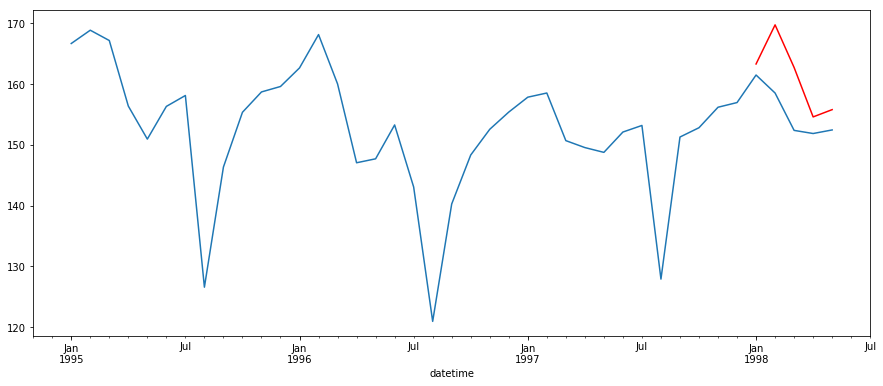

In [140]:
next_year_prediction= stepwise_fit.predict(n_periods=periods)

forecasted_year_series = pd.Series(next_year_prediction, index=t.index)

true_values = t.values

predicted_values = next_year_prediction;

# mse = ((predicted_values - true_values) ** 2).mean()

mse = mean_squared_error(true_values, predicted_values)
print('The Mean Squared Error {}'.format(round(mse, 2)))

ax = pd.Series(x).plot(figsize=(15, 6))

forecasted_year_series.plot(color='red', ax=ax)
plt.show()

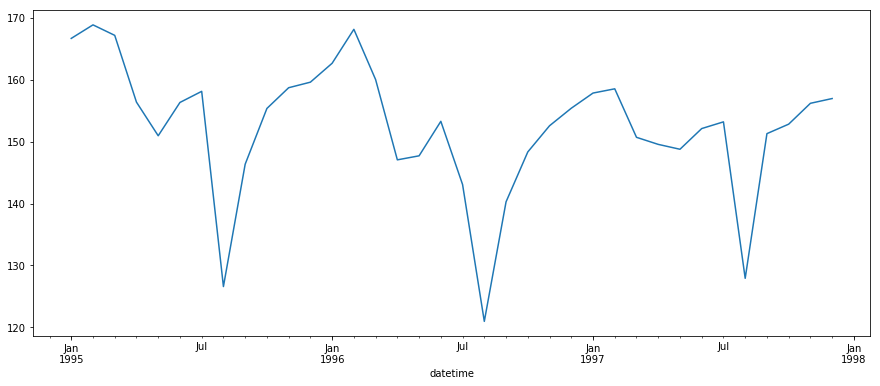

In [63]:
pd.Series(x['main_grid']).plot(figsize=(15, 6))
plt.show()

predicted=149.542752, expected=142.614286
predicted=142.813768, expected=146.414286
predicted=146.665204, expected=145.700000
predicted=145.937324, expected=145.928571
predicted=146.165774, expected=147.857143
predicted=148.117515, expected=153.857143
predicted=154.195077, expected=155.514286
predicted=155.869810, expected=160.842857
predicted=161.263816, expected=151.028571
predicted=151.316605, expected=144.100000
predicted=144.295513, expected=142.857143
predicted=143.034448, expected=143.557143
predicted=143.740982, expected=144.757143
predicted=144.953527, expected=142.485714
predicted=142.652003, expected=136.771429
predicted=136.866867, expected=117.600000
predicted=117.466071, expected=109.457143
predicted=109.228992, expected=121.557143
predicted=121.472342, expected=129.000000
predicted=129.001724, expected=137.814286
predicted=137.916153, expected=140.857143
predicted=140.992055, expected=142.314286
predicted=142.463889, expected=142.857143
predicted=143.011068, expected=143

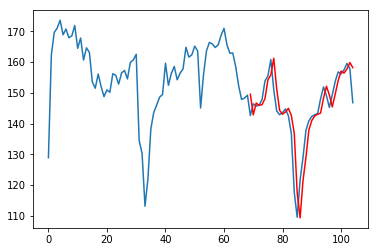

In [128]:
X = y.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
	model = ARIMA(history, order=(0,1,0))
	model_fit = model.fit(disp=0)
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

# plot
plt.plot(X)
plt.plot([(i + len(X) - len(predictions)) for i in range(0, len(predictions))], predictions, color='red')
plt.show()